In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tensorflow.keras.backend import epsilon
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, BatchNormalization, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
from patchify import patchify
from tensorflow.keras.models import load_model

## Load Images and Masks

In [ ]:
# Ensuring that TensorFlow is not locking down too much memory
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
all_tif_files = glob.glob(os.path.join(r'C:\Users\benjm\Downloads\Workspace\Masks\cut', '*.tif'))

# Initialize lists to sort the files
root_mask_images = {}
shoot_mask_images = {}
occluded_root_mask_images = {}
seed_mask_images = {}

# Sorting the files into respective arrays
for file_path in all_tif_files:
    file_name = os.path.basename(file_path)
    image = cv2.imread(file_path, 0)

    if file_name.endswith('_occluded_root_mask.tif'):
        occluded_root_mask_images[file_name] = image
    elif file_name.endswith('_root_mask.tif'):
        root_mask_images[file_name] = image
    elif file_name.endswith('_shoot_mask.tif'):
        shoot_mask_images[file_name] = image
    elif file_name.endswith('seed_mask.tif'):
        seed_mask_images[file_name] = image


In [ ]:
images = [[],[]]
root_masks = [[],[]]
shoot_masks = [[],[]]
occluded_root_masks = [[],[]]
seed_masks = [[],[]]

test_image_files = []
test_image_files.append(glob.glob(os.path.join(r'C:\Users\benjm\Downloads\Workspace\train\cut', '*.png')))
test_image_files.append(glob.glob(os.path.join(r'C:\Users\benjm\Downloads\Workspace\test\cut', '*.png')))
for i, set in enumerate(test_image_files):
    for file_path in set:
        base_name = os.path.splitext(os.path.basename(file_path))[0]
        image = cv2.imread(file_path)
        images[i].append(image)
        root_masks[i].append(root_mask_images.get(base_name + '_root_mask.tif'))
        shoot_masks[i].append(shoot_mask_images.get(base_name + '_shoot_mask.tif'))
        occluded_root_masks[i].append(occluded_root_mask_images.get(base_name + '_occluded_root_mask.tif'))
        seed_masks[i].append(seed_mask_images.get(base_name + '_seed_mask.tif'))

In [61]:
measurement = []
path = r'C:\Users\benjm\Downloads\Workspace\final\cut\test_image_'
for i in range(1, 12):
    measurement.append(cv2.imread(os.path.join(path + str(i) + '.tif')))

In [62]:
len(measurement)

11

## Patching and Padding
 

In [57]:
patch_dir = 'C://Users//benjm//Downloads//Workspace//patches'

In [ ]:
mask_name_list = ['root_masks', 'shoot_masks', 'occluded_root_masks', 'seed_masks'] 

In [63]:
def create_and_save_patches(dataset_type, patch_size, meas = False):
    """
    Splits images and their corresponding masks from a blood cell dataset into smaller patches and saves them.

    This function takes images and masks from a specified dataset type, scales them if needed, and then splits them into smaller patches. Each patch is saved as a separate file. This is useful for preparing data for tasks like image segmentation in machine learning.

    Parameters:
    - dataset_type (str): The type of the dataset to process (e.g., 'train', 'test'). It expects a directory structure like 'blood_cell_dataset/{dataset_type}_images/{dataset_type}' for images and 'blood_cell_dataset/{dataset_type}_masks/{dataset_type}' for masks.
    - patch_size (int): The size of the patches to be created. Patches will be squares of size patch_size x patch_size.
    - scaling_factor (float): The factor by which the images and masks should be scaled. A value of 1 means no scaling.

    Returns:
    None. The function saves the patches as .png files in directories based on their original paths, but replacing 'blood_cell_dataset' with 'blood_cell_dataset_patched'.

    Note:
    - The function assumes a specific directory structure and naming convention for the dataset.
    """
    def padder(image, patch_size):
        """
        Adds padding to an image to make its dimensions divisible by a specified patch size.

        This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

        Parameters:
        - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
        - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

        Returns:
        - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

        Example:
        - padded_image = padder(cv2.imread('example.jpg'), 128)

        """
        h = image.shape[0]
        w = image.shape[1]
        height_padding = ((h // patch_size) + 1) * patch_size - h
        width_padding = ((w // patch_size) + 1) * patch_size - w

        top_padding = int(height_padding/2)
        bottom_padding = height_padding - top_padding

        left_padding = int(width_padding/2)
        right_padding = width_padding - left_padding

        padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        return padded_image
    
    #mask_lists = [root_masks, shoot_masks, occluded_root_masks, seed_masks]

    if measurement:
        for img_idx, image in enumerate(measurement):
            image = padder(image, patch_size)

            # Create image patches
            image_patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
            image_patches = image_patches.reshape(-1, patch_size, patch_size, 3)

            # Save image patches
            for patch_index, img_patch in enumerate(image_patches):
                image_patch_path = f'{patch_dir}//final//{img_idx}_{patch_index}.png'
                cv2.imwrite(image_patch_path, img_patch)

        return

    for img_idx, image in enumerate(images[dataset_type]):
        if not(root_masks[dataset_type][img_idx] is None):
            print(img_idx)
            image = padder(image, patch_size)

            # Create image patches
            image_patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
            image_patches = image_patches.reshape(-1, patch_size, patch_size, 3)

            # Save image patches
            for patch_index, img_patch in enumerate(image_patches):
                image_patch_path = f'{patch_dir}//{dataset_type}_images//{img_idx}_{patch_index}.png'
                cv2.imwrite(image_patch_path, img_patch)

            # Process each type of mask
            for i, mask_list in enumerate(mask_lists):
                mask = mask_list[dataset_type][img_idx]
                mask = padder(mask, patch_size)

                # Create mask patches
                mask_patches = patchify(mask, (patch_size, patch_size), step=patch_size)
                mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

                # Save mask patches
                for patch_index, mask_patch in enumerate(mask_patches):
                    mask_patch_path = f'{patch_dir}//{dataset_type}_masks//{mask_name_list[i]}//{img_idx}_{patch_index}.png'
                    cv2.imwrite(mask_patch_path, mask_patch)

In [64]:
create_and_save_patches(1, 256, meas = True)

In [65]:
def create_weight_map(mask_shape, center_weight=10, border_weight=1):
    """
    Create a weight map for a mask, with higher weights in the center and lower weights at the borders.
    
    :param mask_shape: Tuple, the shape of the mask for which the weight map is created.
    :param center_weight: Float, the weight for the central region of the mask.
    :param border_weight: Float, the weight for the border region of the mask.
    :return: Numpy array, the weight map.
    """
    # Create a grid of the same shape as the mask
    xx, yy = np.meshgrid(np.arange(mask_shape[1]), np.arange(mask_shape[0]))
    
    # Calculate the center of the mask
    center_x, center_y = mask_shape[1] // 2, mask_shape[0] // 2
    
    # Calculate the distance of each point from the center
    distances_from_center = np.sqrt((xx - center_x)**2 + (yy - center_y)**2)
    
    # Normalize distances to range between 0 and 1
    max_distance = np.sqrt(center_x**2 + center_y**2)
    normalized_distances = distances_from_center / max_distance
    
    # Create the weight map where the center has `center_weight` and borders have `border_weight`
    weight_map = (1 - normalized_distances) * (center_weight - border_weight) + border_weight
    
    return weight_map

# Example usage:
mask_shape = (256, 256)  # The shape of your mask patches
weight_map = create_weight_map(mask_shape, center_weight=10, border_weight=1)


In [66]:
class F1Score(Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.round(y_pred), tf.float32)          # for mixed precision training
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)
        true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, "float"), axis=0)
        false_positives = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, "float"), axis=0)
        false_negatives = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), "float"), axis=0)

        self.true_positives.assign_add(tf.reduce_sum(true_positives))
        self.false_positives.assign_add(tf.reduce_sum(false_positives))
        self.false_negatives.assign_add(tf.reduce_sum(false_negatives))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + epsilon())
        return 2 * (precision * recall) / (precision + recall + epsilon())

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

# Define IoU
class IoU(Metric):
    def __init__(self, name='iou', **kwargs):
        super(IoU, self).__init__(name=name, **kwargs)
        self.intersection = self.add_weight(name="intersection", initializer="zeros")
        self.union = self.add_weight(name="union", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.round(y_pred), tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return self.intersection / (self.union + epsilon())

    def reset_state(self):
        self.intersection.assign(0)
        self.union.assign(0)

In [67]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate

def resnet_unet(input_size, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_size, classes=1)

    # Use feature maps from ResNet model
    conv4 = base_model.get_layer('conv4_block6_out').output
    conv3 = base_model.get_layer('conv3_block4_out').output
    conv2 = base_model.get_layer('conv2_block3_out').output
    conv1 = base_model.get_layer('conv1_relu').output

    up4 = UpSampling2D((2, 2))(conv4)
    up4 = concatenate([up4, conv3])
    up4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Dropout(0.2)(up4)
    
    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([up3, conv2])
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Dropout(0.2)(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([up2, conv1])
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Dropout(0.2)(up2)

    up1 = UpSampling2D((2, 2))(up2)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Dropout(0.2)(up1)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


def weighted_loss(y_true, y_pred, weights):
    # Calculate the binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Apply the weights: element-wise multiplication
    weighted_bce = bce * weights
    
    # Return the mean loss
    return tf.reduce_mean(weighted_bce)

def create_weighted_loss(weights):
    def loss(y_true, y_pred):
        return weighted_loss(y_true, y_pred, weights)
    return loss

weight_map_tensor = tf.convert_to_tensor(weight_map, dtype=tf.float32)

weighted_loss_function = create_weighted_loss(weight_map_tensor)

model = resnet_unet(input_size=(256, 256, 3), num_classes=1)
optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer, 
    loss=weighted_loss_function, 
    metrics=[F1Score(), IoU()]
)

In [ ]:
def train_generator(data_gen_args, batch_size, train_path, image_folder, mask_folder, mask_subfolders, target_size=(256,256), seed=1):
    image_datagen = ImageDataGenerator(rescale=1./255, **data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes=[image_folder],
        class_mode=None,
        color_mode="rgb",
        target_size=target_size,
        batch_size=batch_size,
        seed=seed)

    mask_generators = [mask_datagen.flow_from_directory(
        train_path + "//" + mask_folder,
        classes=[subfolder],
        class_mode=None,
        color_mode="grayscale",
        target_size=target_size,
        batch_size=batch_size,
        seed=seed) for subfolder in mask_subfolders]
    
    while True:
        img = image_generator.next()
        mask = [mask_generator.next() for mask_generator in mask_generators]
        batch_weight_maps_tensor = tf.repeat(weight_map_tensor[tf.newaxis, ...], repeats=img.shape[0], axis=0)
        yield (img, mask, batch_weight_maps_tensor)

data_gen_args = dict(
    vertical_flip=True
)
train_gen = train_generator(data_gen_args, batch_size=8, train_path=r"C:\Users\benjm\Downloads\Workspace\patches", image_folder='0_images', mask_folder='0_masks', mask_subfolders= ['root_masks', 'occluded_root_masks'])


In [ ]:
def validation_generator(batch_size, val_path, image_folder, mask_folder, mask_subfolders, target_size=(256, 256), seed=1):
    # Generator for validation images
    image_datagen_val = ImageDataGenerator(rescale=1./255)
    
    # Generator for validation masks (no rescaling needed for masks)
    mask_datagen_val = ImageDataGenerator()

    image_generator_val = image_datagen_val.flow_from_directory(
        val_path,
        classes=[image_folder],
        class_mode=None,
        color_mode="rgb",  # or "grayscale" if your images are grayscale
        target_size=target_size,
        batch_size=batch_size,
        seed=seed)

    mask_generators_val = [mask_datagen_val.flow_from_directory(
        val_path + "//" + mask_folder,
        classes=[subfolder],
        class_mode=None,
        color_mode="grayscale",
        target_size=target_size,
        batch_size=batch_size,
        seed=seed) for subfolder in mask_subfolders]
    
    while True:
        img = image_generator_val.next()
        mask = [mask_generator.next() for mask_generator in mask_generators_val]
        yield (img, mask)

# Example usage
val_gen = validation_generator(batch_size=8, val_path=r"C:\Users\benjm\Downloads\Workspace\patches", 
                               image_folder='1_images', mask_folder='1_masks', 
                               mask_subfolders=['root_masks', 'occluded_root_masks'])


In [ ]:
early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=12, restore_best_weights=True)
history = model.fit(train_gen, steps_per_epoch=80, epochs=80, validation_data=val_gen, validation_steps=486, callbacks=[early_stopping]) #  3888 (patches) / 8 (batch size) = 972 steps

In [68]:
model_path = r'C:\Users\benjm\Downloads\Workspace\modelV10.h5'  # Replace with your actual model file path

# Load the model
model = load_model(model_path, custom_objects={'F1Score': F1Score(), 'IoU': IoU(), 'loss': weighted_loss_function})

# Display the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
val_loss, val_f1_score, val_iou = model.evaluate(val_gen, steps=486)
print("Validation Loss:", val_loss)
print("Validation F1 Score:", val_f1_score)
print("Validation IoU:", val_iou)

In [ ]:
model.save(r'C:\Users\benjm\Downloads\Workspace\modelV10.h5')

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extracting epochs
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

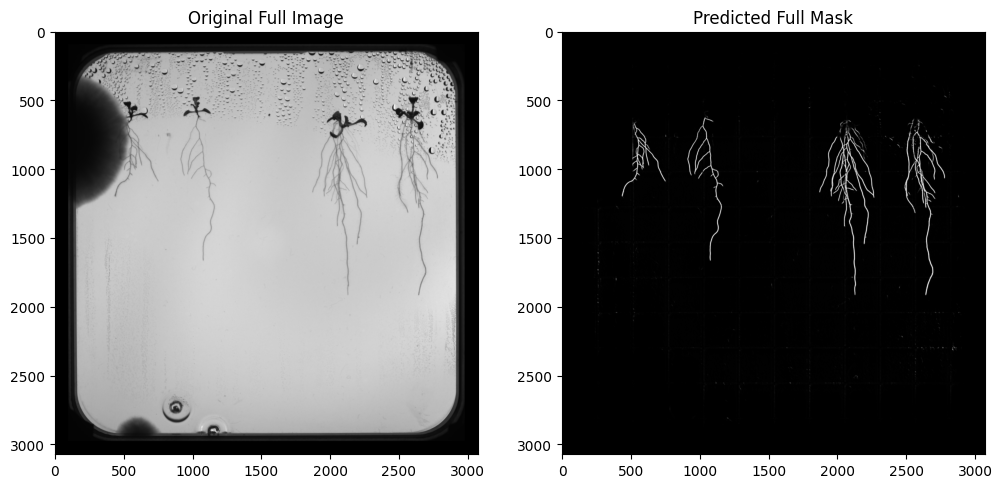

In [70]:
import cv2
import numpy as np
import os
import glob
from patchify import unpatchify

val_img_dir = r'C:\Users\benjm\Downloads\Workspace\patches\final'
val_img_dir = glob.glob(os.path.join(val_img_dir, '*.png'))

# Initialize a dictionary to hold the patches for each image
img_patches = {}

# Load and sort patches
for patch_path in val_img_dir:
    file_name = os.path.basename(patch_path)
    index, patch_index = map(int, file_name.replace('.png', '').split('_'))
    patch_img = cv2.imread(patch_path)

    if index not in img_patches:
        img_patches[index] = {}

    img_patches[index][patch_index] = patch_img

# Now predict masks and reassemble
for index in sorted(img_patches.keys()):
    patches = img_patches[index]
    patch_list = [patches[i] for i in sorted(patches.keys())]

    # Reshape patches for prediction (assuming they are square)
    patch_size = patch_list[0].shape[0]  # Assuming square patches
    num_patches_per_side = int(np.sqrt(len(patch_list)))  # Assuming square layout of patches

    batch_size = 8
    num_patches = len(patch_list)
    patch_list_array = np.array(patch_list)

    predicted_patches = []
    for i in range(0, num_patches, batch_size):
        batch = patch_list_array[i:i + batch_size]
        predicted_mask_batch = model.predict(batch/255)
        predicted_patches.extend(predicted_mask_batch)

    # Convert list of patches into array for unpatchify
    predicted_patches_array = np.array(predicted_patches)
    
    combined_predicted_patches = predicted_patches_array[:,:,:,0]      #np.sum(predicted_patches_array, axis=-1)

    predicted_patches_array = combined_predicted_patches.reshape((num_patches_per_side, num_patches_per_side, patch_size, patch_size))

    patch_list_array = patch_list_array.reshape((num_patches_per_side, num_patches_per_side, patch_size, patch_size, 3))

    def manual_unpatchify(patches, full_image_size):
        num_patches_per_side,_ ,  patch_height, patch_width = patches.shape[:4]
        full_image = np.zeros(full_image_size, dtype=patches.dtype)

        for i in range(num_patches_per_side):
            for j in range(num_patches_per_side):
                if len(patches.shape) == 5:
                    full_image[i * patch_height:(i + 1) * patch_height, j * patch_width:(j + 1) * patch_width, :] = patches[i, j]
                else:  # If patches do not include a channel dimension
                    full_image[i * patch_height:(i + 1) * patch_height, j * patch_width:(j + 1) * patch_width] = patches[i, j]

        return full_image
    # Reconstruct the full image manually
    full_original_image = manual_unpatchify(patch_list_array, (3072, 3072, 3))
    full_predicted_mask = manual_unpatchify(predicted_patches_array, (3072, 3072))

    # save mask
    cv2.imwrite(f'C:\\Users\\benjm\\Downloads\\Workspace\\final\\processed\\test_image_{index}.png', full_predicted_mask*255)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(full_original_image)
plt.title('Original Full Image')

plt.subplot(1, 2, 2)
plt.imshow(full_predicted_mask*255, cmap='gray')
plt.title('Predicted Full Mask')

plt.show()